In [3]:

import matplotlib
matplotlib.use('Agg')

import os
import pandas as pd
import numpy as np
import sys
import pickle
from scipy.spatial.distance import cdist
import math
import networkx as nx
import networkx.algorithms.components.connected as nxacc
import networkx.algorithms.dag as nxadZag
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import mygene
import re

In [4]:

selected_exp_gene_list = pd.read_csv("/data/references/original_data/common_exp_features.tsv",sep="\t")["Gene"].tolist()
selected_mut_gene_list = pd.read_csv("/data/references/original_data/common_mut_features.tsv",sep="\t")["Gene"].tolist()

In [5]:
def load_network(network_file_list, valid_gene_list):
    
    gene_neighbor_map = {}
    
    for file_name in network_file_list:
        
        ## print 'Load network', file_name
        
        file_handle = open(file_name)
    
        for line in file_handle:
        
            line = line.rstrip().split()
            gene1, gene2 = line[0], line[1]
        
            if gene1 not in valid_gene_list or gene2 not in valid_gene_list:
                continue
        
            if gene1 not in gene_neighbor_map:
                gene_neighbor_map[gene1] = set()
            if gene2 not in gene_neighbor_map:
                gene_neighbor_map[gene2] = set()
            
            gene_neighbor_map[gene1].add(gene2)
            gene_neighbor_map[gene2].add(gene1)
            
        file_handle.close()
    
    return gene_neighbor_map
                             
def load_name_space():
        
    go_tab_map = {}
    
    file_handle = open(go_name_space_file)
    
    for line in file_handle:
        line = line.rstrip().split()
        go_tab_map[line[0]] = line[1]
        
    file_handle.close()
    
    return go_tab_map
        
def list2index(cell_line_list, cell_line2id):
    
    cell_line_idx_list = []
    
    for cell_line in cell_line_list:
        cell_line_idx_list.append(cell_line2id[cell_line])
        
    return np.asarray(cell_line_idx_list)

In [13]:
PDTC_data_file = '/data/references/original_data/PDTC/'
PDTC_exp_data_file = PDTC_data_file + 'ExpressionModels.tsv'
PDTC_drug_cell_line_file = PDTC_data_file + 'DrugResponsesAUCModels.tsv'
#download at https://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx

#cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
PDTC_mutation_data_file = PDTC_data_file + 'SNVsModels.tsv'
PDTC_drug_target_file = PDTC_data_file +'drug_target_list.csv'

inbiomap_file = 'InBioMap_Symbol.sif'
pathwaycomm_file = 'PathwayCommons_Symbol.sif'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

data_file = '/data/references/original_data/GDSC/'
new_network_file = '/data/references/original_data/'

exp_data_file = data_file + 'Cell_line_RMA_proc_basalExp.txt'

drug_cell_line_file = data_file + 'v17_fitted_dose_response.csv'
#download at https://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx

cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
mutation_data_file = data_file + 'WES_variants.csv'
drug_target_file = data_file + 'drug_target_list.csv'

feature_folder = 'feature/'

inbiomap_file = 'InBioMap_Symbol.sif'
pathwaycomm_file = 'PathwayCommons_Symbol.sif'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

In [7]:
exp_df = pd.read_csv(exp_data_file, sep=',', index_col=0)
#exp_df = exp_df.T[1:]
#exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
#exp_df = exp_df.drop('NO_GENE_NAME',axis=1)

def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))

exp_df.index = exp_df.index.map(stripNumber)
exp_df = exp_df.groupby(level=0).first()

exp_df = exp_df[selected_exp_gene_list]
exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())


PDTC_exp_df = pd.read_csv(PDTC_exp_data_file, sep='\t', index_col=0).fillna(0)
PDTC_exp_df = PDTC_exp_df.T[1:]
#exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
#exp_df = exp_df.drop('NO_GENE_NAME',axis=1)

def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))

#exp_df.index = exp_df.index.map(stripNumber)
#exp_df = exp_df.groupby(level=0).first()
PDTC_exp_df = PDTC_exp_df[selected_exp_gene_list]

PDTC_exp_gene_list = list(PDTC_exp_df.columns)
PDTC_exp_cell_line_list = list(PDTC_exp_df.index.unique())

exp_df = pd.concat([exp_df,PDTC_exp_df])
exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())
exp_df

,C1orf112,CFH,CFTR,ANKIB1,BAD,CD99,ABP1,CYP26B1,DBNDD1,ALS2,...,CCDC79,C4orf52,CHCHD10,ATP6V1E2,ATXN7L3B,CTSO,ABCC6P1,CLEC12B,CUX1,CLEC5A
683665,4.078870,3.658590,3.117363,8.015309,5.900525,9.516571,3.723836,3.127411,3.291594,3.479082,...,3.381366,6.653091,7.984694,4.348300,6.470045,6.676035,2.553079,2.849990,3.523568,2.774529
683667,3.716740,8.221606,3.196707,8.199868,7.504752,7.823256,3.039047,3.114821,3.657688,3.901545,...,3.104290,7.620034,8.511028,4.873269,5.669516,4.757423,2.817067,2.850488,4.194452,2.856370
684052,3.678987,3.588391,3.086618,7.723643,7.127670,12.100092,3.093593,3.192644,3.698225,4.351939,...,2.938708,7.895173,7.588621,4.481595,7.112424,4.129606,2.667177,2.811825,4.089097,2.852171
684055,3.333385,3.159487,3.063099,8.702543,6.927127,10.756047,3.302694,3.796606,3.855023,4.471301,...,3.105507,7.568713,7.196355,6.006105,7.587148,4.019498,2.752997,2.788439,3.987344,2.862008
684057,3.839433,5.329830,2.977019,8.337328,7.123143,10.714187,3.222643,3.595007,3.851973,4.288931,...,3.323452,7.691629,5.865216,5.169767,6.844792,3.208817,2.777702,2.791408,4.252883,2.926268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHIO131,7.970928,5.742655,6.138248,11.148919,7.722098,6.343462,5.712622,6.670314,7.825870,8.713930,...,5.591894,6.149004,6.929511,7.156418,10.576609,7.252476,5.909093,5.503041,8.390146,5.646287
VHIO161,8.005030,7.784231,5.936787,9.584478,7.622659,9.404361,5.840956,6.268420,7.583436,8.907938,...,5.612150,6.372310,9.702723,6.308929,8.884721,8.556833,5.966753,5.865190,7.267506,6.364706
VHIO169,8.142217,5.952245,6.250779,9.901937,6.984687,8.259999,5.761976,6.419874,7.567103,8.308283,...,5.807190,6.073473,9.038400,7.297878,8.741317,7.362708,5.909084,5.739047,8.132335,5.835559
VHIO179,8.242204,6.536215,6.161589,10.028562,7.783246,8.526129,5.796944,6.445894,8.702552,8.245459,...,5.655400,6.508213,9.873342,7.176497,8.959320,6.580440,5.935516,5.675486,8.065070,5.625879


In [8]:
maf = pd.read_csv(mutation_data_file, sep=',', index_col=0).fillna(0)
mutation_df = maf.groupby(['COSMIC_ID', 'Gene']).size().unstack().fillna(0)
mutation_df = mutation_df[selected_mut_gene_list]


mutation_gene_list = list(mutation_df.columns)
mutation_cell_line_list = list(mutation_df.index.unique())



PDTC_maf = pd.read_csv(PDTC_mutation_data_file, sep='\t', index_col=0).fillna(0)
PDTC_mutation_df= PDTC_maf.replace(to_replace="NO",value=0.0)
PDTC_mutation_df= PDTC_mutation_df.replace(to_replace="chr*",value=1.0,regex=True)
# print len(mutation_cell_line_list), len(mutation_gene_list)
PDTC_mutation_df = PDTC_mutation_df.transpose()
PDTC_mutation_df = PDTC_mutation_df[selected_mut_gene_list]
PDTC_mutation_gene_list = list(PDTC_mutation_df.columns)
PDTC_mutation_cell_line_list = list(PDTC_mutation_df.index.unique())
PDTC_mutation_df


mutation_df = pd.concat([mutation_df,PDTC_mutation_df])
mutation_gene_list = list(mutation_df.columns)
mutation_cell_line_list = list(mutation_df.index.unique())
mutation_df

,ABCA13,ACIN1,ADCY4,AR,ARID1B,BRD7,BZRAP1,CCDC155,CDC27,CKAP4,...,RYR3,SETD1A,SMYD5,SP8,SRRM2,SUPT6H,SYNE1,TCF20,TP53,TTN
683665,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
683667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
684052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
684055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHIO102,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
VHIO124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
VHIO131IGFRES,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
VHIO179,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [11]:
file_handle = open(drug_target_file)

drug_target_map = {}
drug_target_list = []
for line in file_handle:
    
    new_line = line.rstrip().split(",")
    drug = new_line[0]
    target_list=new_line[1].split(',')
    if drug != "Drug":
        target_list_str = ""
        for i in range(0,len(target_list)):
            if i == len(target_list) - 1:
                target_list_str += target_list[i].replace('"','')
            else:
                target_list_str += target_list[i].replace('"','') + ","
        drug = drug.strip()

        drug_target_map[drug] = []
        if ',' not in target_list_str:
            drug_target_map[drug].append(target_list_str.strip())
            drug_target_list.append(target_list_str.strip())
        else:
            target_list = target_list_str.split(',')
            for target in target_list:
                drug_target_map[drug].append(target.strip())
                drug_target_list.append(target.strip())

In [14]:
file_handle = open(PDTC_drug_target_file)
for line in file_handle:
    new_line = line.rstrip().split(",")
    drug = new_line[0]
    target_list=new_line[1:]
    if drug != "Drug":
        target_list_str = ""
        for i in range(0,len(target_list)):
            if i == len(target_list) - 1:
                target_list_str += target_list[i].replace('"','')
            else:
                target_list_str += target_list[i].replace('"','') + ","
        drug = drug.strip()
        if drug not in list(drug_target_map.keys()):
            drug_target_map[drug] = []
        if ',' not in target_list_str:
            drug_target_map[drug].append(target_list_str.strip())
            drug_target_list.append(target_list_str.strip())
        else:
            target_list = target_list_str.split(',')
            for target in target_list:
                drug_target_map[drug].append(target.strip())
                drug_target_list.append(target.strip())

In [15]:
selected_drugs = pd.read_csv("/data/references/original_data/Selected_drugs.csv")["Drug name"].tolist()

In [88]:
drugs_legend = pd.read_csv('/data/references/original_data/GDSC/Screened_Compounds.csv', sep=',', index_col=0)

drug2id_mapping = {}

for index in list(drugs_legend.index) :
    drug_name = drugs_legend.loc[index,'Drug Name']

    drug2id_mapping[ drug_name ] = index
    synonyms = str(drugs_legend.loc[index,"Synonyms"]).split(",")
    for i in synonyms:
        drug = i.strip()
        drug2id_mapping[drug] = index

In [18]:
valid_gene_list = list(set(drug_target_list) | set(exp_gene_list) | set(mutation_gene_list))

network_list = [new_network_file+inbiomap_file, new_network_file+pathwaycomm_file]
gene_neighbor_map =  load_network(network_list, valid_gene_list)

gene_name_df = pd.read_table(new_network_file + 'HUGO_protein-coding_gene.tsv',index_col=25, sep='\t')

gene_name_map = {}

for uniprot_gene in gene_name_df.index:
    ## print uniprot_gene
    if isinstance(uniprot_gene, type('aaa')) == False:
        continue
    
    if isinstance(gene_name_df.loc[uniprot_gene, 'symbol'], type('aaa')) == False:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol'][0]
    else:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol']



/tmp/ipykernel_39/3861621029.py:6: DtypeWarning: Columns (31,38) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_name_df = pd.read_table(new_network_file + 'HUGO_protein-coding_gene.tsv',index_col=25, sep='\t')


In [19]:
corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

uniprot_gene_set = set()

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
        
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    for gene in complex_list:
        uniprot_gene_set.add(gene)

# print len(uniprot_gene_set), 'genes'

query_gene_set = []

for gene in uniprot_gene_set:
    if gene not in gene_name_map:
        query_gene_set.append(gene)
    
# print 'Need to query', len(query_gene_set)

query_gene_list = list(query_gene_set)

mg = mygene.MyGeneInfo()
out = mg.querymany(query_gene_list, scopes='uniprot', fields='symbol', species='human')

not_found_gene_list = []

for i, gene in enumerate(query_gene_list):
    if 'notfound' in out[i]:
        not_found_gene_list.append(gene)
    else:
        gene_name_map[gene] = out[i]['symbol']
        
# print len(not_found_gene_list), 'symbol name not found', len(gene_name_map)

corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
    
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    complex_symbol_list = []
    
    for gene in complex_list:
        if gene in gene_name_map:
            complex_symbol_list.append( gene_name_map[gene] )

    for gene1, gene2 in itertools.combinations(complex_symbol_list,2):
        
        if gene1 not in gene_neighbor_map:
            gene_neighbor_map[gene1] = set()
        if gene2 not in gene_neighbor_map:
            gene_neighbor_map[gene2] = set()
        
        gene_neighbor_map[gene1].add(gene2)
        gene_neighbor_map[gene2].add(gene1)

gene_exp_neighbor_map = {}
exp_matrix = exp_df.values

P = 1 - cdist(np.transpose(exp_matrix), np.transpose(exp_matrix),'correlation')

for i in range(len(exp_gene_list)):
    
    gene1 = exp_gene_list[i]
    gene_exp_neighbor_map[gene1] = set()
    
    for j in range(len(exp_gene_list)):
        
        gene2 = exp_gene_list[j]
        
        if math.fabs(P[i, j]) > 0.4:
            gene_exp_neighbor_map[gene1].add(gene2)
            
    if gene1 not in gene_exp_neighbor_map[gene1]:
        print (gene1, 'not in itself?', P[i,i])



querying 1-43...done.
Finished.
26 input query terms found no hit:
	['Q4ZG51', 'Q9NY11', 'Q3V639', 'Q8IUB6', 'Q8R3P7', 'Q1EHW4', 'Q9NZL9-', 'P01871', 'Q6PJ43', 'P62158'
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [35]:
drug_target_map["AICAR"]

['AAPK1 (AMPK) agonist']

/tmp/ipykernel_39/1800951358.py:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(drug_feature_list,color='r',bins=60,kde=False,norm_hist=False)


<AxesSubplot: >

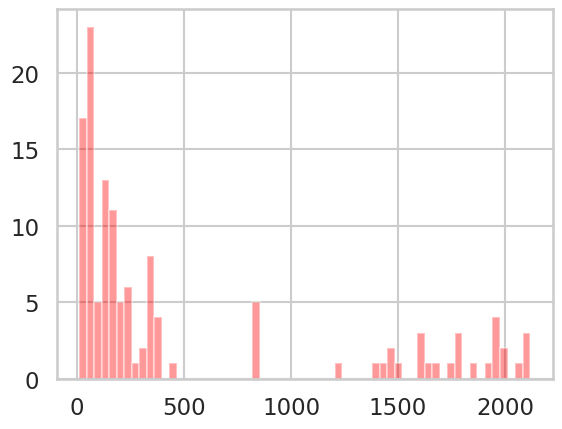

In [89]:
%matplotlib inline
drug_feature_list = []
drug_neighbor_map = {}
selected_drug_list = []

for drug, target_list in drug_target_map.items():
        drug_neighbor_map[drug] = set()

        for gene in target_list:

            if gene not in gene_exp_neighbor_map and gene not in gene_neighbor_map:
                continue

            if gene in gene_exp_neighbor_map:
                drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_exp_neighbor_map[gene]

            if gene in gene_neighbor_map:
                drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_neighbor_map[gene]

        if len(drug_neighbor_map[drug]) != 0:
            selected_drug_list.append(drug)
            drug_feature_list.append( len(drug_neighbor_map[drug]) )
sns.set_style("whitegrid")
sns.set_context("talk")
sns.distplot(drug_feature_list,color='r',bins=60,kde=False,norm_hist=False)

In [91]:
drugs = pd.read_csv(drug_cell_line_file,index_col=2)
drugs = drugs.drop(["DATASET_VERSION","IC50_RESULTS_ID","MAX_CONC_MICROMOLAR","RMSE"],axis=1)
drugs_cell_line_list = list(drugs.index.unique())
# print len(drugs_cell_line_list)
drug_list = drugs["DRUG_ID"]
new_drug_id = []

PDTC_drugs = pd.read_csv(PDTC_drug_cell_line_file,sep='\t',index_col=0)
PDTC_drugs_cell_line_list = list(PDTC_drugs.index.unique())
# print len(drugs_cell_line_list)
drug_list = PDTC_drugs["Drug"].tolist()
new_drug_id = []
for i in drug_list:
    if i in drug2id_mapping.keys():
        new_drug_id.append(drug2id_mapping[i])
    else:
        new_drug_id.append(0)
PDTC_drugs["DRUG_ID"] = new_drug_id
PDTC_drugs["LN_IC50"] = np.log(PDTC_drugs["iC50"])
PDTC_drugs = PDTC_drugs.drop(["Drug","iC50","D1_CONC","D5_CONC","perc.iC50"],axis=1)

drugs = pd.concat([drugs,PDTC_drugs])

drugs_cell_line_list = list(drugs.index.unique())

In [92]:
cell_line_list = list(set(drugs_cell_line_list)&set(exp_cell_line_list)&set(mutation_cell_line_list) )

cell_line_legend = pd.read_csv(cell_line_detail_file, index_col=1)
PDTC_cell_line = pd.DataFrame({'Line': ["BRCA"]*len(PDTC_exp_cell_line_list), 'Site':["PDTC"]*len(PDTC_exp_cell_line_list),"Histology":["breast"]*len(PDTC_exp_cell_line_list)},index=PDTC_exp_cell_line_list)
cell_line_legend = pd.concat([cell_line_legend,PDTC_cell_line])

In [93]:
tissue_map = {}

for cell_line in cell_line_list:
    
    tissue = cell_line_legend.loc[cell_line,'Site']
    
    if tissue not in tissue_map:
        tissue_map[tissue] = []
        
    tissue_map[tissue].append(cell_line)

large_tissue_number = 0
for tissue, cell_line in tissue_map.items():
    
    if len(cell_line) >= 15:
        large_tissue_number += 1
    
    print (tissue, len(cell_line))

print('How many tissues', len(tissue_map))
print('Large tissues', large_tissue_number)

lung 169
haematopoietic_and_lymphoid_tissue 163
central_nervous_system 56
stomach 28
bone 40
pancreas 32
large_intestine 48
soft_tissue 22
urinary_tract 19
autonomic_ganglia 29
oesophagus 35
upper_aerodigestive_tract 42
ovary 41
breast 50
cervix 13
PDTC 19
endometrium 11
thyroid 15
skin 55
liver 16
adrenal_gland 1
vulva 3
prostate 7
biliary_tract 5
kidney 31
salivary_gland 2
pleura 21
NS 3
testis 2
placenta 2
small_intestine 1
How many tissues 31
Large tissues 20


In [94]:
new_exp_gene_list = []
for i in exp_gene_list:
    if i in valid_gene_list:
        new_exp_gene_list.append(i)

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

new_data_file = ''

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]



In [95]:
selected_drug_list= list(set(selected_drug_list) & set(selected_drugs))

In [98]:
rename_selected_drug_list = []

for drug in selected_drug_list:
    print(drug)
    
    if drug not in drug2id_mapping:
        print('drug name wrong', drug)
    else:
        cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == drug2id_mapping[drug]]
        
        feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list) )
        feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list) )
        if len(feature_exp_gene_list) + len(feature_mut_gene_list) == 0:
            continue
        feature_description = []

        drug_tissue_map = {}

        drug = drug.replace(' ','_')

        rename_selected_drug_list.append(drug)

        # print drug
        if drug == 'Nutlin-3a_(-)':
            drug = 'Nutlin-3a'

        drug_folder = '/data/drug_features/GDSC1_PDTC/drug_feature/' + drug + '/'
        if not os.path.exists(drug_folder):
            os.makedirs(drug_folder)

        # print 'Generate features', drug

        for tissue, tissue_cell_line_list in tissue_map.items():
            drug_specific_cell_line = set( cell_line_drug_matrix.index ) & set( tissue_cell_line_list )
            drug_specific_cell_line = list(drug_specific_cell_line)
            drug_tissue_map[tissue] = drug_specific_cell_line

            feature_list = []

            if len(feature_exp_gene_list) != 0:
                feature_list.append( new_exp_df.loc[ drug_specific_cell_line, feature_exp_gene_list ].values )
                for gene in feature_exp_gene_list:
                    feature_description.append(gene+'_expression')

            if len(feature_mut_gene_list) != 0:
                feature_list.append( mutation_df.loc[ drug_specific_cell_line, feature_mut_gene_list ].values )
                for gene in feature_mut_gene_list:
                    feature_description.append(gene+'_mutation')

            feature = np.concatenate(feature_list, axis=1)

            label = cell_line_drug_matrix.loc[ drug_specific_cell_line,'LN_IC50'].values

            #label = new_crispr_df.loc[ tissue_cell_line_list, label_gene ].values

            # print feature.shape, label.shape

            np.save(drug_folder + tissue + '_' + drug + '_feature.npy', feature )
            np.save(drug_folder + tissue + '_' + drug + '_label.npy', label)
            np.save(drug_folder + tissue + '_feature_description.npy', np.asarray(feature_description))

        drug_tissue_map = {k: v for k, v in drug_tissue_map.items() if len(v) > 0}
        if len(drug_tissue_map) > 1:
            file_handle = open("/data/drug_features/GDSC1_PDTC/" + drug+'_tissue_cell_line_list.pkl',"wb")
            pickle.dump(drug_tissue_map,file_handle)
            file_handle.close()
        else:
            print(f"too little features:{drug}")
            os.system(f"rm -R {drug_folder}")

file_handle = open('rename_selected_drug_list', 'w')
for drug in rename_selected_drug_list:
    file_handle.writelines(drug+ '\n')
file_handle.close()

CEP-701
Sorafenib
RO-3306
MK-2206
Gefitinib
TW 37
JQ1
SL 0101-1
AZD7762
PD-0332991
FK866
681640
GSK-1904529A
Embelin
SB 216763
PD-173074
ZM-447439
Axitinib
KU-55933
AZ628
AG-014699
PLX4720
Camptothecin
Bosutinib
BMS-536924
BX-795
CHIR-99021
JNJ-26854165
AMG-706
GW 441756
BMS-754807
Obatoclax Mesylate
GSK269962A
BI-2536
